In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display
from IPython.core.pylabtools import figsize

import os
import sys
import time
import json
import glob
import numpy as np
import pandas as pd
import numpy.random as nr
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid

import torchvision as tv
import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


# Autocodificadores Variacionais

<table align='left'>
<tr><td> <img src="../figures/vae.png"> </td></tr>
</table>    

In [2]:
images_dir = '/data/datasets/CelebA/img_align_celeba/'
len(glob.glob(images_dir + '/*.jpg'))

202599

In [3]:
class CelebADataset(Dataset):
    images_dir = '/data/datasets/CelebA/img_align_celeba'
    
    def __init__(self, nb_images=202599, is_validation=True, transforms=None, valid_split=0.25):
        image_count = len(glob.glob(images_dir + '/*.jpg'))
        assert nb_images <= image_count
        self.total_images = nb_images
        self.split_index = int(self.total_images * valid_split)
        self.is_validation = is_validation
        self.nb_vimages = self.split_index
        self.nb_timages = self.total_images - self.nb_vimages
        self.transforms = transforms
        
    def __len__(self):
        return self.nb_vimages if self.is_validation else self.nb_timages
    
    def __getitem__(self, index):
        if not self.is_validation:
            index += self.split_index
        path = '{}/{:06d}.jpg'.format(self.images_dir, index+1)
        with open(path, 'rb') as f:
            with Image.open(f) as img:
                image = img.convert('RGB')                
        if self.transforms is not None:
            image = self.transforms(image)
        return image, image

def get_celeba_data_loaders(total_images, batch_size=100, flatten=False):
    tf_list = [tv.transforms.ToTensor()]
    if flatten:
        tf_list.append(lambda x: x.view(-1))
    transf = tv.transforms.Compose(tf_list)
    train_ds = CelebADataset(total_images, valid_split=0.25, transforms=transf)
    valid_ds = CelebADataset(total_images, valid_split=0.25, transforms=transf, is_validation=True)
    train_dloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dloader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
    return train_dloader, valid_dloader


(218, 178, 3)


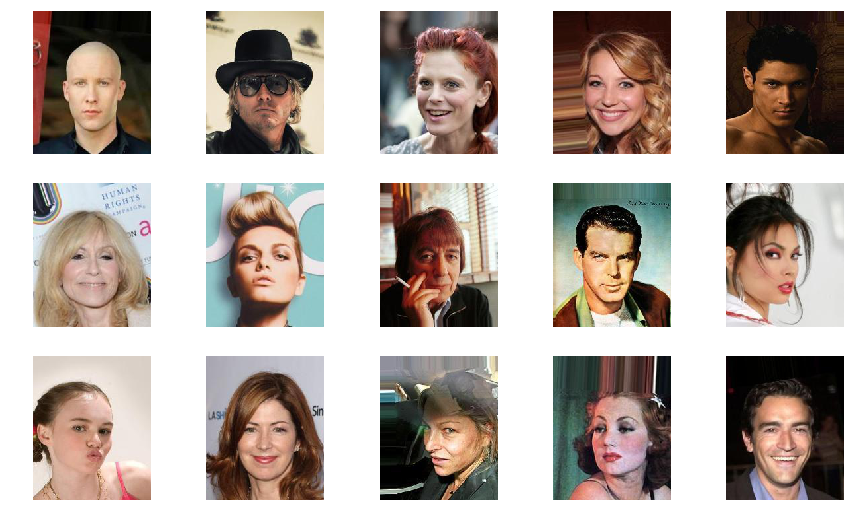

In [4]:
fig = plt.figure(figsize=(15, 9))

tra_dloader, val_dloader = get_celeba_data_loaders(1000, 15)
for images, images in tra_dloader:
    for i, img in enumerate(images):
        plt.subplot(3, 5, i+1)
        img = img.numpy().transpose(1, 2, 0)
        plt.imshow(img)
        plt.axis('off')
    break
    
print(img.shape)

In [5]:
# ---------------------------
# Imagens 3 x 218 x 178
# ---------------------------
class VAEConv(nn.Module):
    
    def __init__(self, nz, nc=3, ngf=64, ndf=64):
        super().__init__()
        
        self.encoder = nn.Sequential(
            # input is (nc) x 218 x 178
            nn.Conv2d(nc, ndf, kernel_size=3, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 109 x 89
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 54 x 44
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 27 x 22
            nn.Conv2d(ndf * 4, 1, kernel_size=5, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
        
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # state size. (ngf*2) x 7 x 7
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        output = self.main(input)
        return output


class VAE(nn.Module):
    def __init__(self, flatten_dim, latent_dim, intermediate_dim):
        super(VAE, self).__init__()

        self.flat_dim = flatten_dim
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.fc1  = nn.Linear(flatten_dim, intermediate_dim)
        self.fc21 = nn.Linear(intermediate_dim, latent_dim)
        self.fc22 = nn.Linear(intermediate_dim, latent_dim)
        self.fc3  = nn.Linear(latent_dim, intermediate_dim)
        self.fc4  = nn.Linear(intermediate_dim, flatten_dim)

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.flat_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [6]:
def vae_loss(recon_x, x, mu, logvar):
    
    # (1) cross-entropy
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)

    # (2) Kullback–Leibler divergence
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    # KLD /= batch_size * flatten_dim

    return BCE + KLD


In [7]:
class MyTrainer(ptt.DeepNetTrainer):
    
    def _do_optimize(self, X, Y):
        self.optimizer.zero_grad()
        X_recon, mu, logvar = self.model.forward(X)
        loss = self.criterion(X_recon, X, mu, logvar)
        loss.backward()
        self.optimizer.step()
        return X_recon, loss
    
    def _do_evaluate(self, X, Y):
        X_recon, mu, logvar = self.model.forward(X)
        loss = self.criterion(X_recon, X, mu, logvar)
        return X_recon, loss
    
    def predict_loader(self, data_loader):
        recons = []
        vmean  = []
        logvar = []
        for X, _ in data_loader:
            if self.use_gpu:
                X = Variable(X.cuda())
            else:
                X = Variable(X)
            x, mu, var = self.model.forward(X)
            recons.append(x.cpu())
            vmean.append(mu.cpu())
            logvar.append(var.cpu())
        recons = torch.cat(recons, 0)
        vmean = torch.cat(vmean, 0)
        logvar = torch.cat(logvar, 0)
        return recons, vmean, logvar

    
class MySaveImagesCallback(ptt.Callback):
    
    def __init__(self, base_filename):
        self.base_fn = base_filename
    
    def on_vbatch_end(self, epoch_num, batch_num, X, y, X_recon, loss):
        if batch_num == 0 and epoch_num % 2 == 0:
            n = min(X.size(0), 8)
            comparison = torch.cat([X.view(batch_size, 3, 218, 178)[:n], 
                                    X_recon.view(batch_size, 3, 218, 178)[:n]])
            save_image(comparison.data.cpu(), self.base_fn + '_{:03d}.png'.format(epoch_num), nrow=n)            


In [8]:
trainIt = True
resetIt = False

n_epochs = 30
batch_size = 10
n_images = 1000
flatten_dim = 3 * 218 * 178
latent_dim = 100
intermediate_dim = 512

tra_loader, tst_loader = get_celeba_data_loaders(n_images, batch_size, flatten=True)
vae_net = VAE(flatten_dim, latent_dim, intermediate_dim)
optimizer = Adam(vae_net.parameters(), lr=1e-3)
if use_gpu:
    vae_net = vae_net.cuda()
    
# Callbacks
# ---------
images_bfn = '../../images/vae_recon'
model_bfn = '../../models/vae_celeba_01'
chkpt_cb = ptt.ModelCheckpoint(model_bfn, reset=resetIt, verbose=1)
print_cb = ptt.PrintCallback()
plot_cb = ptt.PlotCallback()
save_cb = MySaveImagesCallback(images_bfn)

training_parameters = {
    'model':         vae_net, 
    'criterion':     vae_loss, 
    'optimizer':     optimizer, 
    'callbacks':     [save_cb, chkpt_cb, print_cb],
}
trainer = MyTrainer(**training_parameters)

if trainIt:
    trainer.fit_loader(n_epochs, tra_loader, tst_loader)

else:
    trainer.load_state(model_bfn)
    print('\nTraining disabled.\nThis model was trained for {} epochs.'.format(trainer.last_epoch))

Start training for 30 epochs
  1:  75.9s   T: 85991682183564144.00000   V: 112137.06425 best
  2:  74.4s   T: 107951.85850   V: 85680.61225 best
  3:  73.7s   T: 86223.58350   V: 83584.25700 best
  4:  67.6s   T: 83378.01250   V: 126368.58300 
  5:  66.7s   T: 88488.66350   V: 86785.86200 
Best model was saved at epoch 3 with loss 83584.25700: ../../models/vae_celeba_01
Stop training at epoch: 5/30


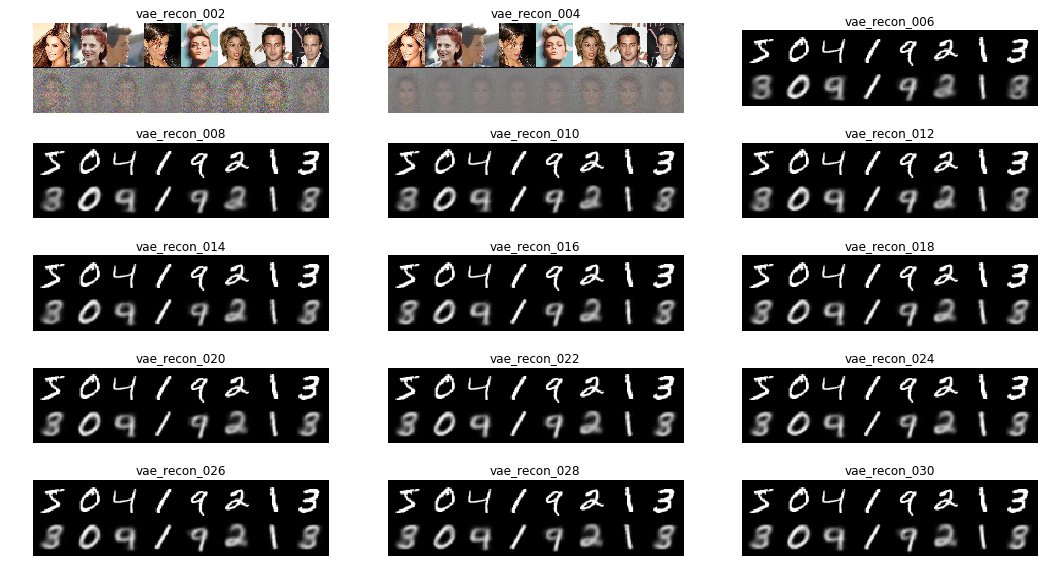

In [9]:
ifns = sorted(glob.glob(images_bfn + '*.png'))
n = len(ifns)
rows = np.ceil(n / 3)
fig = plt.figure(figsize=(18, 2*rows))
for i, fn in enumerate(ifns):
    title = os.path.basename(fn)[:-4]
    fig.add_subplot(rows, 3, i+1)
    img = plt.imread(fn)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title)
 

In [10]:
n = 10
for i in range(4):
    a = nr.randint(0, len(tst_loader.dataset))
    b = nr.randint(0, len(tst_loader.dataset))

    fig = plt.figure(figsize=(20, 2))

    img1, _ = tst_loader.dataset[a]
    img2, _ = tst_loader.dataset[b]
    img1 = img1.view(28, 28)
    img2 = img2.view(28, 28)
    
    plt.subplot(1, n+2, 1)
    plt.imshow(img1.numpy(), cmap=plt.cm.gray)
    plt.axis('off')
    plt.subplot(1, n+2, n+2)
    plt.imshow(img2.numpy(), cmap=plt.cm.gray)
    plt.axis('off')

    images = Variable(torch.cat([img1, img2]).view(2, -1))
    if use_gpu:
        images = images.cuda()
    (code_a, code_b), _ = vae_net.encode(images)

    vec = code_b - code_a
    for i, q in enumerate(torch.linspace(0.0, 1.0, n)):
        v = code_a + q * vec
        v = torch.unsqueeze(v, 0)
        img = vae_net.decode(v)
        img = img.view(img1.shape)
        plt.subplot(1, n+2, i+2)
        plt.imshow(img.data.cpu().numpy(), cmap=plt.cm.gray)
        plt.axis('off')

RuntimeError: invalid argument 2: size '[28 x 28]' is invalid for input of with 116412 elements at /Users/soumith/miniconda2/conda-bld/pytorch_1503975723910/work/torch/lib/TH/THStorage.c:41